# Viewing and changing solver options

This notebook will showcase:

* How to view the solver options
* How to change the solver options

In [1]:
import ucompress as uc
import matplotlib.pyplot as plt

## Motivation

Due to the nonlinear nature of the governing equations, the solvers in `ucompress` are not guaranteed to converge.  The could be due to the tolerances in the solvers being too strict.  Alternatively, the user may wish to increase the tolerances to increase simulation speed or decrease them to ensure the equations are being accurately solved.

As an example, let's consider the force-controlled compression of a fibre-reinforced material.  The force will be fixed at $F = -0.30$ Newtons:

In [2]:
# Define parameters
pars = uc.parameters.example_parameters.FibreRecruitment(nondim = True)
pars.update('F', -0.38)

# Define model properties
mech = uc.mechanics.FibreRecruitment()
perm = uc.permeability.Constant()

# Build the model
model = uc.base_models.Poroelastic(mech, perm, pars)

# Attempt to solve the problem
problem = uc.experiments.ForceControlled(model, pars)
sol = problem.transient_response()

--------------------------------
Transient step
Newton iterations did not converge at step 0 (t = 4.00e-06)


As we see, the nonlinear solver, which is based on Newton's method, did not converge at the first time step.  One way to remedy this situation is to increase the solver tolerances.

## Viewing the solver options

The default solver options are stored as a dictionary in an attribute in the `problem` object

In [3]:
print(problem.solver_opts)

{'jacobian': 'analytical', 'monitor_convergence': False, 'newton_max_iterations': 10, 'abs_tol': 1e-08, 'rel_tol': 1e-08, 'div_tol': 1e+20}


Here's a summary of the items in the dictionary:

* **jacobian** (string) - can be set to either `analytical` or `numerical`.  This string determines whether the nonlinear solver uses an analytical or numerical Jacobian matrix in Newton iterations.  The numerical Jacobian matrix is computed using finite differences.
* **monitor_convergence** (boolean) - can be True or False.  Flag that controls whether convergence information is printed to the screen during time stepping.
* **newton_max_iterations** (int) - an integer that controls the maximum number of iterations in Newton's method.  If convergence is not reached after the maximum number of iterations, then the method is assumed to have not converged.
* **abs_tol** (float) - sets the absolute residual error tolerance needed for convergence.  That is, convergence occurs if $|F_n| < \text{abs\_tol}$ where $F_n$ is the residual at the $n$-th Newton iteration.
* **rel_tol** (float) - sets the relative residual error tolerance needed for convergence.  That is, convergence occurs if $|F_n| / |F_0| < \text{rel\_tol}$.
* **div_tol** (float) - sets the absolute residual error that defines solver *divergence*.  The solver is assumed to have not converged to a solution if $|F_n| > \text{div\_tol}$.

## Changing the solver options

There are two ways that the solver options can be changed.  The first is to overwrite the default entries in the `solver_opts` attribute.  In the example below, we turn on convergence monitoring to gain some insight into why the method is not converging:

In [4]:
# Change solver options
problem.solver_opts['monitor_convergence'] = True

# Attempt to re-solve
sol = problem.transient_response()

--------------------------------
Transient step
----solving iteration 0----
norm(F) = 1.5005e+01
norm(F) = 3.4768e+00
norm(F) = 1.1399e+00
norm(F) = 3.0441e-01
norm(F) = 7.9601e-02
norm(F) = 2.3420e-02
norm(F) = 1.1946e-02
norm(F) = 7.7700e+00
norm(F) = 1.9252e+00
norm(F) = 4.8478e-01
Newton iterations did not converge at step 0 (t = 4.00e-06)


We see that during the iterations, the relative norm of the residual decreases below $10^{-2}$.  Increasing the relative tolerance will prevent the solver from not converging (although the solution approximation may not be a good one):

In [5]:
# Change solver options
problem.solver_opts['monitor_convergence'] = False
problem.solver_opts['rel_tol'] = 1e-2

# Attempt to re-solve
sol = problem.transient_response()

--------------------------------
Transient step
Solver converged
Average number of Newton iterations per time step: 1.2


We can plot the solution and see that it doesn't look too bad

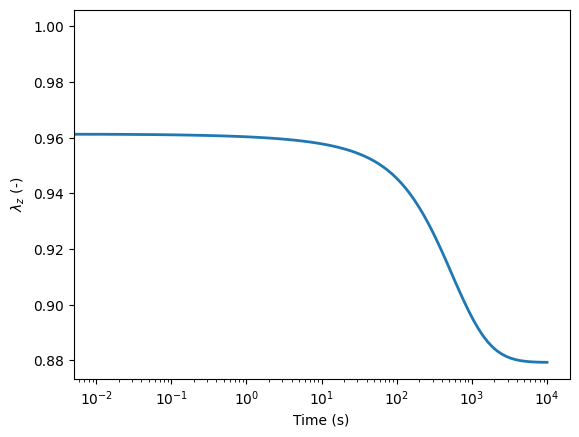

In [6]:
# Re-dimensionalise the soln then plot
sol.redimensionalise(pars)
plt.semilogx(sol.t, sol.lam_z, lw = 2)
plt.xlabel('Time (s)')
plt.ylabel(r'$\lambda_z$ (-)')
plt.show()

One can also pass a dictionary with solver options to the `transient_response` method:

In [7]:
# Define the force-controlled experiment
problem = uc.experiments.ForceControlled(model, pars)

# Define custom solver options
solver_opts = {
    'jacobian': 'analytical',
    'monitor_convergence': False,
    'newton_max_iterations': 8,
    'abs_tol': 1e-6,
    'rel_tol': 1e-2,
    'div_tol': 1e10
}

# Solve with custom solver options
sol = problem.transient_response(solver_opts = solver_opts)

--------------------------------
Transient step
Solver converged
Average number of Newton iterations per time step: 1.2


## A warning

Use caution when increasing the solver tolerances to avoid convergence issues.  Although there can be legitimate reasons to increase the solver tolerances, it does come with the risk of the governing equations not being satisfied.  Other approaches to overcoming convergence issues are changing the size of the time steps or changing the parameter values.